## Aligning Open-ST metastatic lymph node

In this tutorial, we will illustrate how to perform the alignment of the 3 serial sections from a [human metastatic lymph node profiled with Open-ST](https://doi.org/10.1016/j.cell.2024.05.055), that we just preprocessed with `spacemake` and `openst`.

Make sure you have activated the `openst` environment you created previously.

## Installing dependencies

We will install [`STIM`](https://www.biorxiv.org/content/10.1101/2021.12.07.471629v3) (both the Java-based components, and the Python bindings)

```bash
mamba install -c conda-forge stim
pip install stimwrap
pip install scanpy
```

## Running from Jupyter

First of all, you must have a Python environment with [ipykernel](https://ipython.readthedocs.io/en/stable/install/kernel_install.html) for running this notebook, or [Jupyter](https://jupyter.org/). If so, you can run the steps below as an interactive notebook.

### Importing `stimwrap`

[`STIM`](https://www.biorxiv.org/content/10.1101/2021.12.07.471629v3) is a console-based tool.

However, when running your analysis in the `Python` ecosystem (like here), you can transparently run `STIM` from `Python` by leveraging the wrapper [`stimwrap`](https://github.com/rajewsky-lab/stimwrap).

`stimwrap` provides bindings for all commands, and additional tools for data preprocessing and conversion prior to downstream analysis.

In [1]:
import stimwrap as st

In [2]:
st.set_bin_path("/home/user/mambaforge/envs/malva/bin") # change depending on your conda environment

'/home/user/mambaforge/envs/malva/bin'

### Creating a N5 container from `AnnData` objects

STIM requires that the individual section data is resaved into a single N5 container.

This allows to have a single directory containing all data (spatial expression values), metadata (cell annotations), and the output from STIM registration (landmarks, transformation matrices).

You can find more about the N5 standard here.

!!! note
    In this tutorial, we assume you could pairwise-align and segment all sections. However, you can also do 3D registration of *hexbin* objects, which are created automatically by `spacemake`. In that case, adapt the paths accordingly.

In [6]:
import glob
import os
import re

workdir = "/home/user/openst_demo"
spacemake_folder = "spacemake/projects/mLN/processed_data/mLN_*/multimodal"
sections = glob.glob(os.path.join(workdir, spacemake_folder, "stitched_segmented.h5ad"))
sections_numbers = [2, 3, 4]
sections_numbers, sections = zip(*sorted(zip(sections_numbers, sections)))

# we create an alias because STIM needs unique file names
for section, number in zip(sections, sections_numbers):
    alias = re.search(r'mLN_S\w+', section).group(0)
    directory = os.path.dirname(section)
    link_path = os.path.join(os.path.join(directory, f"{alias}_stitched_segmented.h5ad"))
    if os.path.exists(link_path):
        os.remove(link_path)
    os.symlink(section, link_path)

sections = glob.glob(os.path.join(workdir, spacemake_folder, "*_stitched_segmented.h5ad"))
sections_numbers = [2, 3, 4]
sections_numbers, sections = zip(*sorted(zip(sections_numbers, sections)))

print(*[f"Section ID: {s}; Z-axis: {n}" for s, n in zip(sections, sections_numbers)], sep="\n")

Section ID: /home/user/openst_demo/spacemake/projects/fc_sts_063/processed_data/fc_sts_063_2/multimodal/fc_sts_063_2_stitched_segmented.h5ad; Z-axis: 2
Section ID: /home/user/openst_demo/spacemake/projects/fc_sts_063/processed_data/fc_sts_063_3/multimodal/fc_sts_063_3_stitched_segmented.h5ad; Z-axis: 3
Section ID: /home/user/openst_demo/spacemake/projects/fc_sts_063/processed_data/fc_sts_063_4/multimodal/fc_sts_063_4_stitched_segmented.h5ad; Z-axis: 4


In [7]:
sections

('/home/user/openst_demo/spacemake/projects/fc_sts_063/processed_data/fc_sts_063_2/multimodal/fc_sts_063_2_stitched_segmented.h5ad',
 '/home/user/openst_demo/spacemake/projects/fc_sts_063/processed_data/fc_sts_063_3/multimodal/fc_sts_063_3_stitched_segmented.h5ad',
 '/home/user/openst_demo/spacemake/projects/fc_sts_063/processed_data/fc_sts_063_4/multimodal/fc_sts_063_4_stitched_segmented.h5ad')

Make sure the sections are in order, because these will be used as the relative Z-axis order.

With the code above, we have sorted the files according to their names, which contain the Z-axis offset (equal to section number).

Now, we add the slices into a single N5 container:

In [8]:
container_path = os.path.join(workdir, "openst_metastatic_lymph_node.n5")

st.add_slices(container=container_path, inputs=sections)

[2024-10-30T13:21:49,394] [main] INFO : Log level set to: INFO
[2024-10-30T13:21:49,471] [main] INFO : Container '/home/user/openst_demo/openst_metastatic_lymph_node.n5' is new ...
[2024-10-30T13:21:49,621] [main] INFO : Linked dataset '/home/user/openst_demo/spacemake/projects/fc_sts_063/processed_data/fc_sts_063_2/multimodal/fc_sts_063_2_stitched_segmented.h5ad' to container '/home/user/openst_demo/openst_metastatic_lymph_node.n5'.
[2024-10-30T13:21:50,527] [main] INFO : Log level set to: INFO
[2024-10-30T13:21:50,603] [main] INFO : Container '/home/user/openst_demo/openst_metastatic_lymph_node.n5' exists
[2024-10-30T13:21:50,750] [main] INFO : Linked dataset '/home/user/openst_demo/spacemake/projects/fc_sts_063/processed_data/fc_sts_063_3/multimodal/fc_sts_063_3_stitched_segmented.h5ad' to container '/home/user/openst_demo/openst_metastatic_lymph_node.n5'.
[2024-10-30T13:21:51,647] [main] INFO : Log level set to: INFO
[2024-10-30T13:21:51,723] [main] INFO : Container '/home/user/ope

### Pairwise registration

As indicated in its name, STIM will handle ST data as images. These are multi-channel images where the XY dimensions can be specified by a scaling factor (e.g., 1:1 to map 1 pixel to 1 ST unit), and the channels are genes.

During pairwise registration, STIM will automatically find corresponding points between pairs of sections for a subset of genes, and keep those with _high quality/agreement_ across all genes for a pair of sections. This is required prior to assembling a global alignment model (when more than 2 sections are provided).

A subset of genes is used to avoid registering with all genes (in sequencing-based ST, this can lead to ~30,000 channels). This might be too time-consuming, and also most genes do not have sufficient information to render images with spatial patterns that can be used for feature detection (sparsity problem). By default, STIM detects genes with highest variance as a proxy for genes that might show suitable spatial patterns. Otherwise, the user can specify a set of genes used to render images for pairwise alignment. This is what we will do in this tutorial.

This assumes that you have installed `scanpy`. You can do that by running
```bash
pip install scanpy
```

Then, you can use it to detect highly variable genes, following the typical workflow for single-cell/spatial analysis

In [9]:
# Run the code below if you get issues with __DATA_TYPES__
container = st.Container(container_path)
container.cleanup_container()

/home/user/mambaforge/envs/malva/lib/python3.11/site-packages/stimwrap/_stimwrap.py:399: FutureWarning: The N5Store is deprecated and will be removed in a Zarr-Python version 3, see https://github.com/zarr-developers/zarr-python/issues/1274 for more information.
  self.container: zarr.N5Store = zarr.N5Store(self.path)


In [10]:
import scanpy as sc
import h5py

# Compute common genes
common_genes = set([g.decode("utf-8") for g in h5py.File(sections[0], 'r')['var/_index'][:].tolist()])
for s in sections[1:]:
    with h5py.File(s, 'r') as s_data:
        common_genes.intersection(set([g.decode("utf-8") for g in s_data['var/_index'][:].tolist()]))

# Load one of the sections; these data is already normalized
adata = sc.read_h5ad(sections[0])

# Filter and normalize
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_counts=50)
sc.pp.filter_cells(adata, max_counts=10000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

# Subset to genes common across all sections
adata = adata[:, adata.var_names.isin(common_genes)]

# Detect and select highly variable genes (common across all sections), this leads to 15 of them
sc.pp.highly_variable_genes(adata, flavor="seurat", min_mean=0.2, max_mean=0.6)
hvg_genes = adata.var_names[adata.var['highly_variable']].tolist()

/home/user/mambaforge/envs/malva/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:693: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [11]:
hvg_genes

['CD74',
 'COL1A1',
 'COL1A2',
 'COL3A1',
 'IGHG3',
 'RPL13A',
 'RPL23A',
 'RPL27A',
 'RPL32',
 'RPLP2',
 'RPS12',
 'RPS23',
 'RPS27',
 'RPS29',
 'RPS6']

!!! note
    Adding more genes might increase the accuracy of pairwise alignment, but 10 seems to be enough for this example dataset. Adding more genes increases the time required for pairwise alignment.

In [12]:
# we remove `adata` from memory because it is not required anymore
import gc
del adata
gc.collect()

706

Now, we run the pairwise alignment with the `hvg_genes`

In [14]:
st.align_pairs(container=container_path,
               max_epsilon=0,
               genes = hvg_genes[:10],
               range = 2,
               scale = 0.03, # if you use the hexbin, set to 0.0003
               num_threads = 8,
               overwrite=True)

[2024-10-30T13:23:29,229] [main] INFO : Log level set to: INFO
[2024-10-30T13:23:29,462] [main] WARN : No input datasets specified. Trying to open all datasets in '/home/user/openst_demo/openst_metastatic_lymph_node.n5' ...
[2024-10-30T13:23:29,463] [main] INFO : Opening 3 datasets
[2024-10-30T13:23:29,850] [main] WARN : Could not read annotation 'puck_id'. Skipping
[2024-10-30T13:23:30,481] [main] WARN : Could not read annotation 'puck_id'. Skipping
[2024-10-30T13:23:30,980] [main] WARN : Could not read annotation 'puck_id'. Skipping
[2024-10-30T13:23:31,330] [main] WARN : Parameter maxEpsilon is unset or negative; using 10 * average distance between sequenced locations = 3210.8364692356026
[2024-10-30T13:23:31,330] [main] INFO : Overwriting previous results for: fc_sts_063_2_stitched_segmented.h5ad-fc_sts_063_4_stitched_segmented.h5ad
[2024-10-30T13:23:31,336] [main] INFO : Retrieving standard deviation of genes for all sections
[2024-10-30T13:23:31,348] [main] INFO : Aligning fc_sts

**Importantly**, if you try to run pairwise alignment more than once, you need to specify the argument `overwrite=True` when calling `st.align_pairs`.

Otherwise, `STIM` assumes that pairwise alignment was performed and will exit.

### Visualization of results

!!! note
    To run the interactive visualization or alignment tools via `st.align_pairs_view`, `st.align_interactive` or `st.explorer`, make sure you are running this notebook in a computer with a graphical environment, or that you are doing redirection of the window server (e.g., X11 redirection via `ssh -X ...`).

    You can learn more about this [here](https://goteleport.com/blog/x11-forwarding/).

It is good practice to manually assess the results of pairwise alignment before proceeding or using these data for analysis, as the set of parameters used for registration might have not been suitable for the data at hand. Some reasons leading to poor alignment might be:

- Poor selection of the subset of genes used for alignment
- Scale (or render factor) parameter too large or too small
- Poor selection of alignment error (`--maxEpsilon`) parameter
- Data is too noisy and might need some filtering (e.g., with `--ffMedian` or `--ffSingleSpot`)

STIM provides GUI-based tools to interactively assess the result from pairwise alignment:

In [ ]:
st.align_pairs_view(container=container_path,
                    datasets=[s[2:] for s in sections],
                    gene=hvg_genes[0])

Alternatively, you can use an interactive pairwise alignment tool to find suitable parameters, iteratively

In [ ]:
st.align_interactive(container=container_path,
                     section_a=sections[0],
                     section_b=sections[1])

### Global alignment

Once you are satisfied with the results from the pairwise alignment of pairs of sections, you can proceed with the global alignment. 

This last step optimizes a global model taking into account all pairs of keypoints. 

This reduces error propagation across sections, which might lead to very large distortions in the reconstruction.

In [15]:
st.align_global(container=container_path,
                skip_icp=True)

[2024-10-30T14:01:06,116] [main] INFO : Log level set to: INFO
[2024-10-30T14:01:06,347] [main] WARN : No input datasets specified. Trying to open all datasets in '/home/user/openst_demo/openst_metastatic_lymph_node.n5' ...
[2024-10-30T14:01:06,773] [main] WARN : Could not read annotation 'puck_id'. Skipping
[2024-10-30T14:01:07,466] [main] WARN : Could not read annotation 'puck_id'. Skipping
[2024-10-30T14:01:08,007] [main] WARN : Could not read annotation 'puck_id'. Skipping
i=0: 0=0.0 1=0.27046238733935246 2=0.0 
i=1: 0=0.27046238733935246 1=0.0 2=1.0 
i=2: 0=0.0 1=1.0 2=0.0 
[2024-10-30T14:01:08,466] [main] INFO : Prealigned all tiles
Shuffling took 0 ms
First apply took 49 ms
Concurrent tile optimization loop took 1820 ms, total took 1869 ms
[2024-10-30T14:01:10,346] [main] INFO : Global optimization of 3
[2024-10-30T14:01:10,347] [main] INFO :    Avg Error: 1371.906349455969px
[2024-10-30T14:01:10,347] [main] INFO :    Min Error: 1310.9160679095392px
[2024-10-30T14:01:10,348] [ma

### Visualization of results

Similarly as before, it is good practice to visualize the results after the global alignment procedure. 

STIM can leverage `BigDataViewer` for 3D visualization of these data:

In [ ]:
st.bdv_view3d(input=container_path,
              genes=hvg_genes)

!!! note
    To run `BigDataViewer`, similarly to above, make sure you are running this notebook in a computer with a graphical environment, or that you are doing redirection of the window server (e.g., X11 redirection via `ssh -X ...`).

### Storing the 3D coordinates in `AnnData`

Prior to analysing these objects with `scanpy` or other tools from the `scverse` ecosystem, you can apply the transformation model 
and store the transformed 3D coordinates as a new layer in the `AnnData` (or `N5`) objects.

In [20]:
# load N5 container with stimwrap
container = st.Container(container_path)
container.cleanup_container()

In [ ]:
# iterate over datasets and apply the computed transformation
for z_axis, dataset_name in zip(sections_numbers, container.get_dataset_names()):
    with container.get_dataset(dataset_name, mode="r+") as dataset:
        dataset.apply_save_transform(transformation="model_sift",
                                     locations='spatial',
                                     destination='spatial_transform_sift',
                                     z_coord=z_axis)

### Demo: interoperability with `scanpy`

Here, we showcase the interoperability of STIM (via `AnnData`-backed N5) by plotting genes and running some data processing with `scanpy`.

First of all, you can create a single `AnnData` object that can be loaded at once with `scanpy` (all cells in the same file).

In [18]:
import scanpy as sc

In [22]:
import anndata as ad

adata_concatenated = ad.concat([ad.read_h5ad(adata_path) for adata_path in sections], join='inner', index_unique="_")
adata_concatenated.write_h5ad(os.path.join(workdir, "metastatic_lymph_node_aligned.h5ad"))

##### Note

If you get errors in the cell above because of `__DATA_TYPES__` or because of `column-order`, run the following command:

In [23]:
# run if necessary (comment out line below)
container.cleanup_container()

#### Plotting gene expression

We transpose the Z-axis coordinates for plotting with scanpy (from a different point of view)

In [24]:
adata_concatenated.obsm['spatial_transform_sift_plotting'] = adata_concatenated.obsm['spatial_transform_sift'][:, [2, 0, 1]]

We use the `pl.embedding` function for faster plotting (also, axes are scaled to the same magnitude). One can alternatively use the `pl.spatial` function

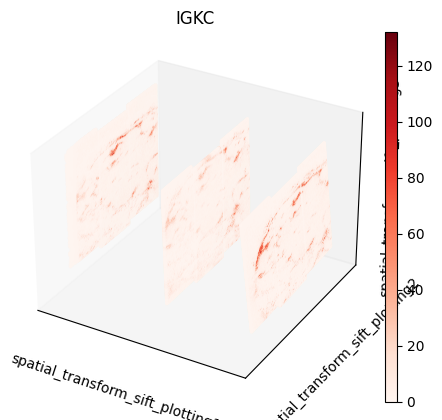

In [25]:
sc.pl.embedding(adata_concatenated, color=['IGKC'], projection='3d', size=1, basis='spatial_transform_sift_plotting', cmap='Reds')

#### Plotting normalized gene expression

In the plot above, raw counts are shown. As different sections had different sequencing depth, the intensities are not fully comparable. 

For improved visualization (and downstream analysis), we can normalize the values across sections. This follows the typical scanpy workflow.

In [26]:
# Filter and normalize
sc.pp.calculate_qc_metrics(adata_concatenated, inplace=True)
sc.pp.filter_cells(adata_concatenated, min_counts=50)
sc.pp.filter_cells(adata_concatenated, max_counts=10000)
sc.pp.normalize_total(adata_concatenated, inplace=True)
sc.pp.log1p(adata_concatenated)

Now we can plot again, which will show depth and log-normalized counts.

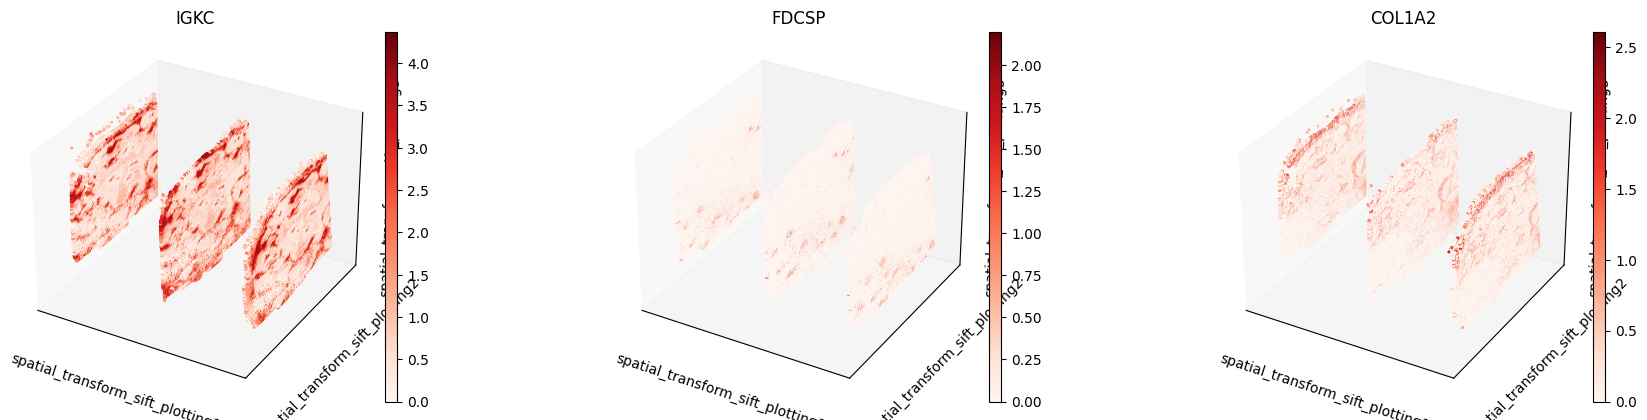

In [27]:
sc.pl.embedding(adata_concatenated, color=['IGKC', 'FDCSP', 'COL1A2'], projection='3d', size=1, basis='spatial_transform_sift_plotting', cmap='Reds')

From here we can proceed with downstream analysis, like cell type clustering, differential expression, discovery of spatial features...